# Bag of words
## KOS blog entries: orig source: dailykos.com 
### Downloading and extracting

In [98]:
import os
import classicdb.fetch as fetch

url = "https://sites.google.com/site/xchgdir/public/kos.tar.gz?attredirects=0&d=1"
data_home = fetch.get_data_home()
classic_home = os.path.join(data_home, "kos_home")
print("download and extracting file from " + url)
fetch.download_and_unzip(url, classic_home, "kos.tar.gz")
print("downloaded and extracted to " + classic_home)
corpus_root = os.path.join(classic_home, "kos")

download and extracting file from https://sites.google.com/site/xchgdir/public/kos.tar.gz?attredirects=0&d=1


downloaded and extracted to C:\Users\lmamani\scikit_learn_data\kos_home


### Parsing and loading into memory

In [99]:
import os

vocabfile = os.path.join(corpus_root, "vocab.kos.txt")
with open(vocabfile, 'r') as f:
    vocab = [line.strip() for line in f.readlines()]

bagdicts = []
docwordfile = os.path.join(corpus_root, "docword.kos.txt")
with open(docwordfile, 'r') as f:
    for line in f.readlines():
        w = line.strip().split()
        if len(w) == 3:
            docid = int(w[0]) - 1
            wordid = int(w[1]) - 1
            wordcount = int(w[2])
            if len(bagdicts) <= docid:
                bagdicts.append({})  # add new dictionary
            dict = bagdicts[docid]
            # dict[vocab[wordid]] = wordcount  #
            dict[wordid] = wordcount  # add new (key, value) into dictionary 
print(len(vocab), "words in vocabulary")
print(len(bagdicts), "documents")

6906 words in vocabulary
3430 documents


### Constructing "counting" matrix (is not in order)

In [110]:
import numpy as np
from sklearn.feature_extraction import DictVectorizer

v = DictVectorizer(sparse=False)
counts = v.fit_transform(bagdicts)
print("cols = frequency by term, row = frequency by file")
print(counts)
print()
for f in range(0, 3):
    print("file #", f, "has", int(np.sum(counts[f])), "terms")
print("...")

cols = frequency by term, row = frequency by file
[[ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]

file # 0 has 137 terms
file # 1 has 77 terms
file # 2 has 157 terms
...


### Calculating TFID

In [117]:
from sklearn.feature_extraction.text import TfidfTransformer
from time import time

t0 = time()
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(counts)
print("done in %fs" % (time() - t0))
print("m samples: %d, n features: %d" % tfidf.shape)
print()

print("TFID matrix")
print(tfidf.toarray())
print()

print("Weights of each feature computed by fit")
print(transformer.idf_)

done in 0.352000s
m samples: 3430, n features: 6906

TFID matrix
[[ 0.          0.          0.         ...,  0.          0.08710494  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]

Weights of each feature computed by fit
[ 7.75431268  5.80840253  5.96255321 ...,  5.70661984  5.45172759
  6.57565769]


### Clustering using k-means (3 clusters)

In [92]:
from time import time
from sklearn.cluster import KMeans

clusters = 3
km = KMeans(n_clusters=clusters,
            init='k-means++',  # or 'random'  
            n_init=10,  # repetition of the process to choose the best
            max_iter=300  # iterations for kmeans
            )

print("Document clustering with %s" % km)
start = time()
km.fit(tfidf)
print("done in %0.3fs" % (time() - start))
print()

print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % vocab[ind], end='')
    print()

Document clustering with KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


done in 2.066s

Top terms per cluster:
Cluster 0: november account electoral governor poll senate polls house republicans vote
Cluster 1: bush kerry iraq president war campaign general house poll administration
Cluster 2: dean edwards clark kerry lieberman primary gephardt poll iowa democratic


### Dendogram 

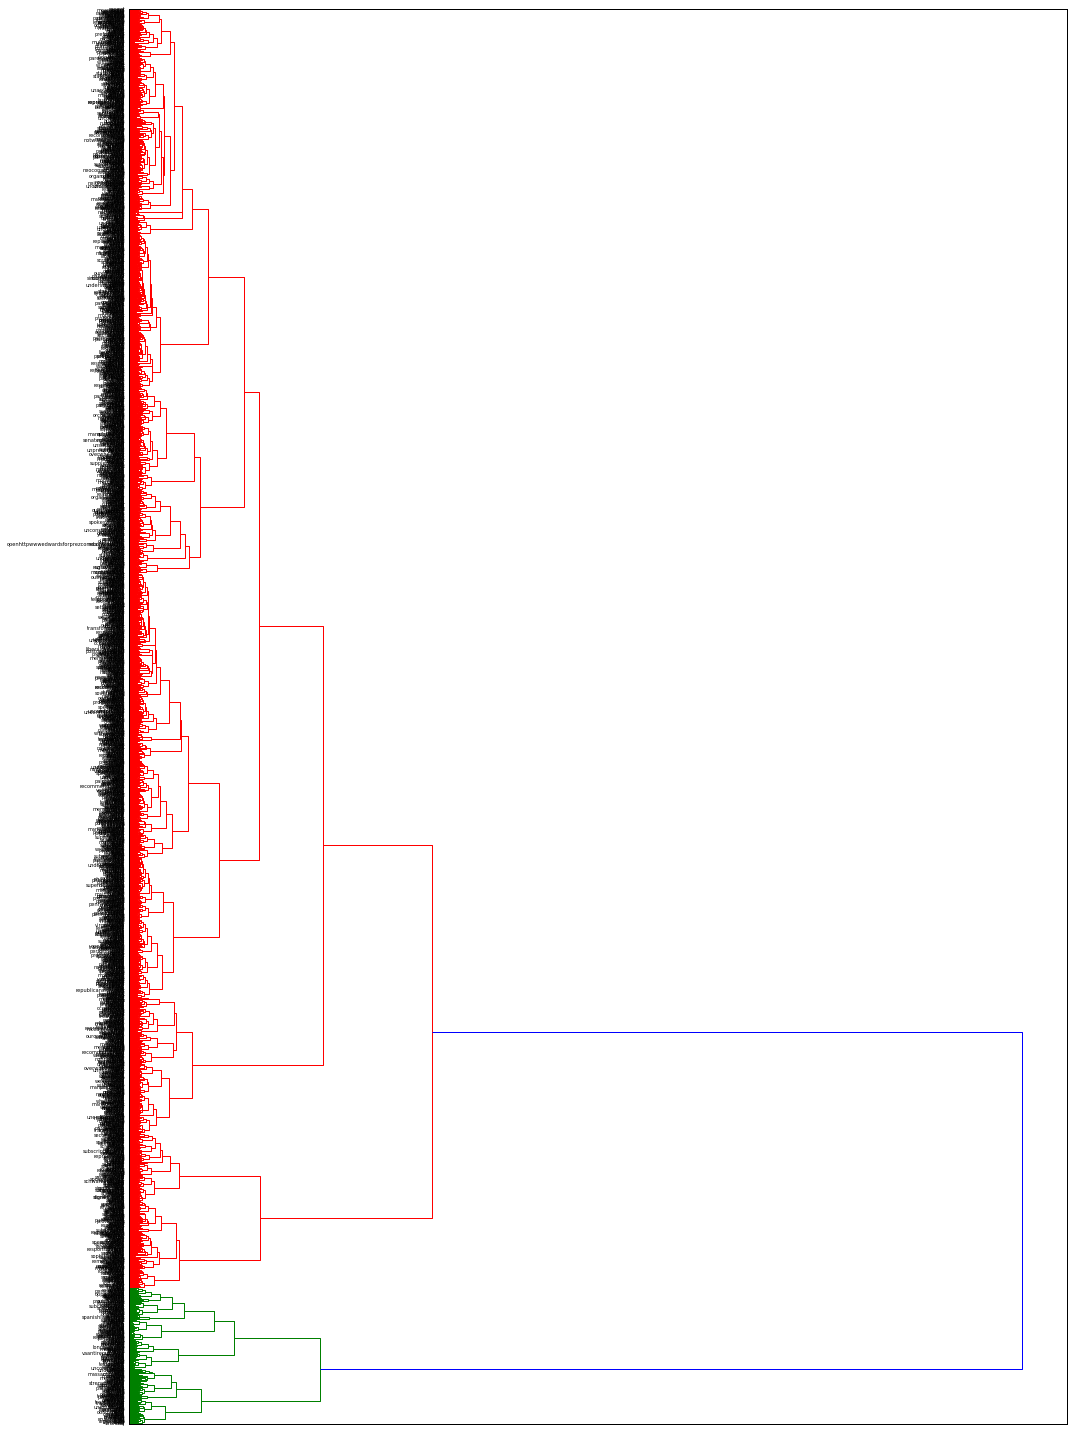

In [118]:
% matplotlib inline

from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram

dist = 1 - cosine_similarity(tfidf)
linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(15, 20))
ax = dendrogram(linkage_matrix, orientation="right", labels=vocab)
plt.tick_params(
    axis='x',  # changes apply to the x-axis
    which='both',  # both major and minor ticks are affected
    bottom='off',  # ticks along the bottom edge are off
    top='off',  # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout()  #show plot with tight layout